## Credit Card Fraud Detection
February, 2025

### 1. Introduction
#### 1.1 Background and objectives

Fraudulent credit card transections cause significant amount of losses to credit card companies and their customers. It is estimated that in the United States, such loss amounts to 12.5 billion dollars in 2023. Techniques and tools to detect the fraudulent transections are therefore very important for credit card companies.
#### 1.2 Data

This study uses the **Credit Card Fraud Detection** dataset contributed by the Machine Learning Group - UL on kaggle.com, which contains credit card transactions in two days of September 2013 by European cardholders. 

***Dataset citation***<br>
ULB (Université Libre de Bruxelles) (2017). Credit Card Fraud Detection. Retrieved on January 29, 2025 from https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data.

***Loading required libraries***

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import ParameterGrid
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
import lightgbm as lgb
from xgboost import XGBClassifier
from time import time
import warnings

warnings.simplefilter(action = 'ignore',category = FutureWarning)
warnings.simplefilter(action = 'ignore',category = UserWarning)

### 2. Exploratory Data Analysis and Data Cleaning

> According to the authors, the original features in the credit transection dataset cannot be provided due to confidentiality concerns. Instead, PCA transformation was performed to generate features V1, V2, … V28. In addition, two original features remain in the dataset:  'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset and 'Amount' is the transaction amount. Finally, feature 'Class' is the binary label indicating fraud transection (value 1) or otherwise (value 0).

In [2]:
data = pd.read_csv('card\creditcard.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

- The dataset contains 284,807 rows and 31 columns, all of which in numerical data type and no missing data presents.

***Removing duplicates (if any)***

In [3]:
data.drop_duplicates(ignore_index=True, inplace=True)
print(data.shape)

(283726, 31)


***Distribution of features***

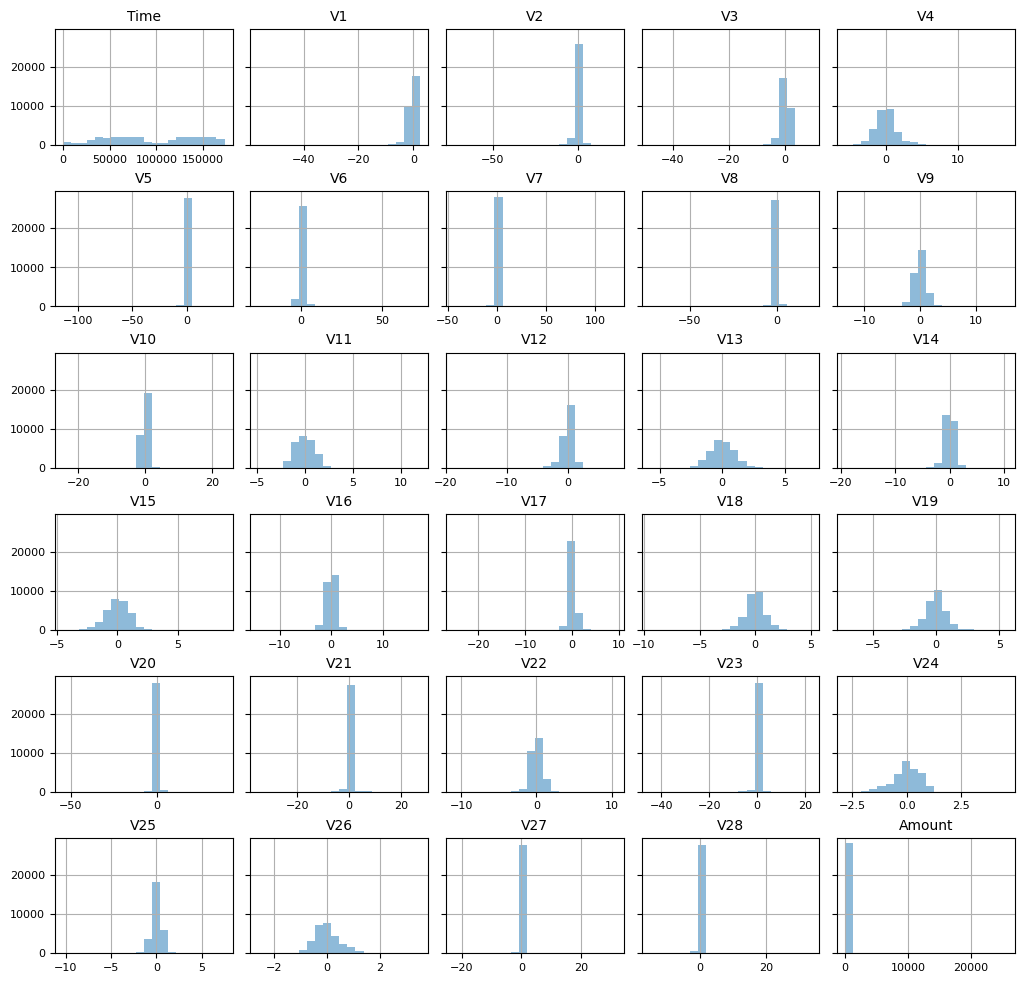

In [4]:
fig,ax = plt.subplots(6,5,figsize=(12,12),sharey=True,squeeze=True)
fig.subplots_adjust(left=0.1, wspace=0.1,hspace=0.4)
for i, axi in enumerate(ax.flatten()):
    plt.subplot(6,5,i+1)
    data.iloc[:,i].hist(bins=20, alpha = 0.5, ax=axi)
    axi.set_xticklabels(axi.get_xticklabels(),fontsize=8)
    if i in [0,5,10,15,20,25]:
        axi.set_yticklabels(axi.get_yticklabels(),fontsize=8)
    axi.set_title(data.columns[i],fontsize=10)
plt.show()

- Except for the 'Time' and 'Amount' features, the PCA-generated features have similar range of values. Several features show significant skewness and presence of outliers, such as 'V2', 'V5', 'V7', 'V8', 'V23' and 'Amount'. Since detecting fraud often involves identifying unusual or anomalous behavior, which means outliers might be indicative of fraudulent activity, they should not be removed. Instead, feature engineering tools such as standardization or transformation can be utilized to mitigate the skewed distribution of the data as well as improve model performance. 

***Correlations among features***

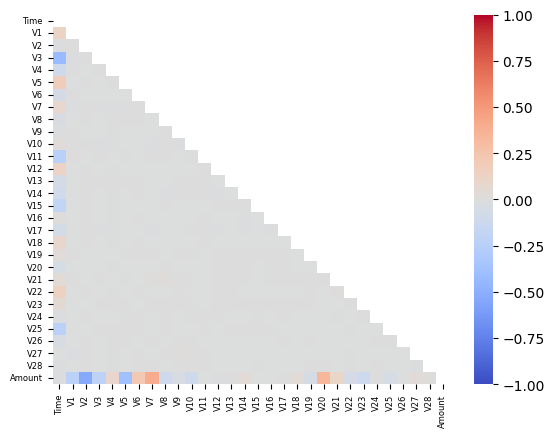

In [10]:
corr_mat = data.iloc[:,:-1].corr()
g=sns.heatmap(corr_mat, mask=np.triu(corr_mat), vmin=-1, vmax=1, cmap='coolwarm') #
g.set_yticks(np.arange(0.5,30,1))
g.set_yticklabels(corr_mat.columns, fontsize=6)
g.set_xticks(np.arange(0.5,30,1))
g.set_xticklabels(corr_mat.columns, fontsize=6)
plt.show()

- No significant correlation was discovered among the features, largely attributed to the PCA preprocessing.

***Feature reduction***<br>
- Although the dataset already consists of PCA features, the dimension of feature space is still relatively high. With 283.7k observations and 30 features, the computational complexity is high for certain classifiers. It is worthwhile to explore if some of the features are less important in separating the target classes, and therefore can be removed.



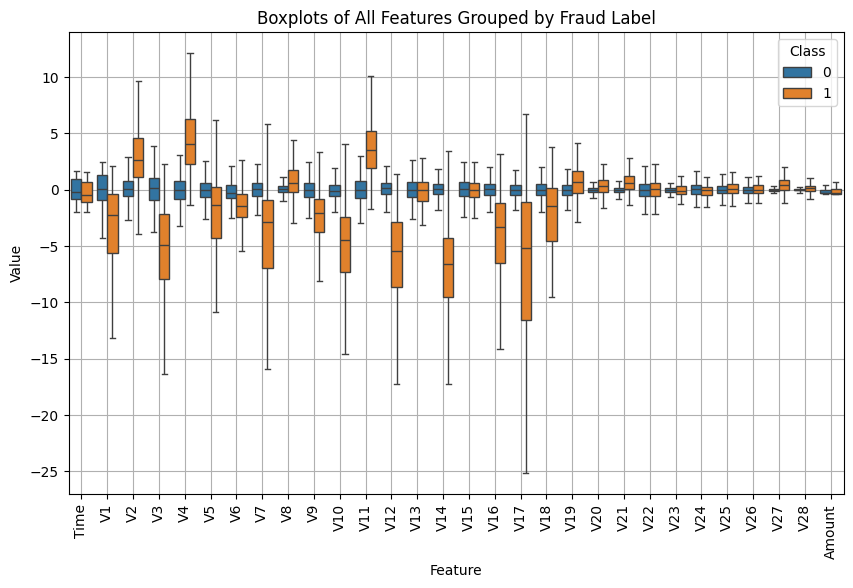

In [5]:
X = data.copy()
X[['Time', 'Amount']] = StandardScaler().fit_transform(X[['Time', 'Amount']])

# Melt the DataFrame to long-form for seaborn
X_melted = pd.melt(X, id_vars='Class', value_vars=X.columns[:-1],
                    var_name='Feature', value_name='Value')
plt.figure(figsize=(10, 6))
g = sns.boxplot(x='Feature', y='Value', hue='Class', data=X_melted,showfliers=False)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.grid(True)
plt.title('Boxplots of All Features Grouped by Fraud Label')
plt.show()


- Variables such as Time, V13, V15, V22, V25, V26 do not have distinct distributions in the fraud/non-fraud groups and are likely less important for classification models.

***Feature significance based on ANOVA F-test***

- The f_classif function in scikit-learn is used for performing an ANOVA F-test for feature selection. It evaluates the significance of each feature in predicting the target classification. ANOVA F-test compares the variances between groups (classes) with the variances within each group to determine if the mean differences between the groups are statistically significant. A higher F-value indicates a stronger relationship with the target variable.


Features NOT statistically significant:['V15' 'V25']


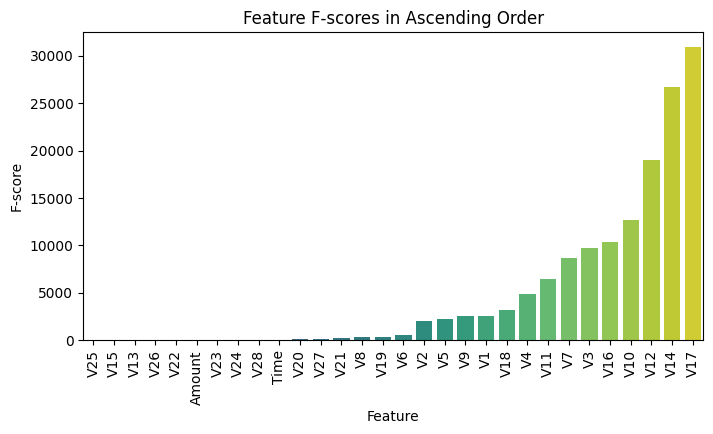

In [4]:
from sklearn.feature_selection import f_classif
y = data['Class']
X = data.drop('Class', axis=1)
f_scores, p_values = f_classif(X, y)
# Rank features by F-score
f_score_df = pd.DataFrame(data=np.array([f_scores,p_values]).T,index=X.columns,columns=['F-score','p-value'])
print(f"Features NOT statistically significant:{f_score_df[f_score_df['p-value']>0.05].index.values}")
f_score_df = f_score_df.sort_values(by='F-score')
sorted_feature_names = f_score_df.index.to_list()

_,ax = plt.subplots(figsize=(8, 4))
sns.barplot(y='F-score', x=f_score_df.index, data=f_score_df, palette='viridis',ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Feature F-scores in Ascending Order')
plt.ylabel('F-score')
plt.xlabel('Feature')
plt.show()

***Balance of classes***

- **The class labels are found to be severely imbalanced**: number of "fraud" cases ('Class' = 1) is less than 0.2% of the total cases. Such imbalance can lead to poor model performance unless measures are taken to artificially augment the representation of the positive class.

In [6]:
data.Class.value_counts()/len(data)

Class
0    0.998333
1    0.001667
Name: count, dtype: float64

### 3. Feature Engineering

#### 3.1 Data Augmentation
- When one class is severely underrepresented in a binary classification problem, it's often beneficial to address this class imbalance to improve model performance.

- Here, we will use the Scikit-learn's **SMOTE** (Synthetic Minority Over-sampling Technique) function which generates synthetic samples by interpolating between existing minority class samples. The **sampling_strategy** parameter of SMOTE which determines the fraction of the minority class in the new dataset can also be tuned to improve model performance. Therefore, SMOTE will be built into a modeling pipeline in the grid search cross validation procedure. 

- Note that SMOTE will only be applied to the training set, while the test set remains unchanged for independent evaluation.

- Increasing the sample size with SMOTE can impact the training time significantly for some classification algorithms. It is prudent to evaluate such impact and determine an appropriate degree of oversampling to ensure the efficiency for model training. The steps to take will be:

    1. Split the original data into train and test sets
    2. Use GridSearchCV to find the best SMOTE sampling_strategy parameter, which determins the fraction of the augmented minority class in th final sample (the training set).


##### 3.1.1 Data Preprocessing

In [22]:
X = data.drop('Class', axis=1)
y = data['Class']
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X, columns=data.columns[:-1])

# 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)
print(np.sum(y_train),np.sum(y_test))
# Apply SMOTE to the training data
# smote = SMOTE(sampling_strategy = 0.01, random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Verify class distribution after SMOTE
# print(sorted(Counter(y_train).items()))
# print(sorted(Counter(y_train_smote).items()))
# print("Original minority/majority ratio:", np.sum(y==1)/np.sum(y==0))#y_train.value_counts())
# print("New minority/majority ratio after SMOTE:", np.sum(y_train_smote==1)/np.sum(y_train_smote==0))#y_train_smote.value_counts())

361 112


##### 3.1.2 Tuning SMOTE for LogisticRegression

[Text(0.5, 23.52222222222222, 'smote sampling_stategy'),
 Text(50.722222222222214, 0.5, 'logisticregression C')]

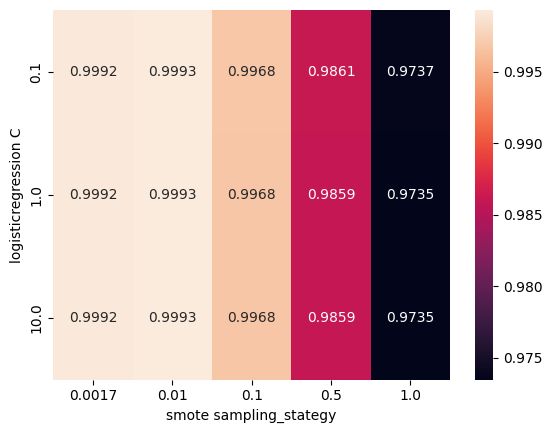

In [73]:
pipeline = make_pipeline(
    SMOTE(random_state=99), 
    StandardScaler(),
    LogisticRegression(random_state=99)
)

# Define the hyperparameters to tune
param_grid = {
    'smote__sampling_strategy': [0.0017, 0.01, 0.1, 0.5, 1.0],
    'logisticregression__C': [0.1, 1.0, 10.0]
}

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=20, scoring='accuracy', n_jobs=-1)

# Train the model with GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model accuracy
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print(f'Best Hyperparameters: {best_params}')
# print(f'Best Cross-Validated Score: {best_score:.2f}')

results = grid_search.cv_results_
g = sns.heatmap(np.reshape(results['mean_test_score'],(3,5)),annot=True,fmt='.4g',
            xticklabels=list(param_grid.values())[0],
           yticklabels=list(param_grid.values())[1])
g.set(xlabel='smote sampling_stategy',ylabel='logisticregression C')
plt.show()

For logistic regression, using SMOTE to increase the minority class only leads to slight (almost unnotieable) improvements to training accuracy when the fraction of the positive class was increased from 0.0017 to 0.01. Further augmentation leads to decreased accuracy. This is likely attributed to the class weights in sklearn's logisticregression being automatically adjusted by the class fractions. Let's look at the effect of minority class augmentation in the random forest classifier.

##### 3.1.2 Tuning SMOTE for RandomForestClassifier

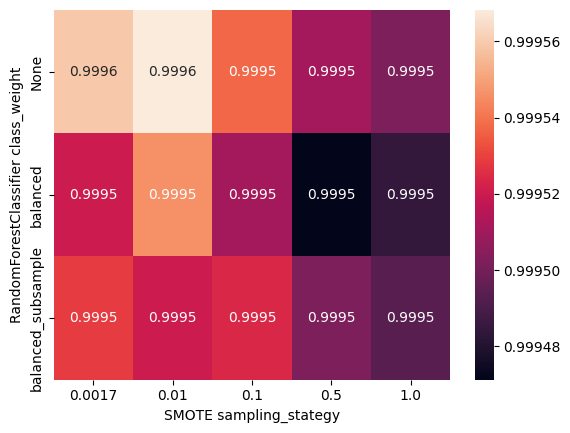

In [86]:
pipeline = make_pipeline(
    SMOTE(random_state=99), #sampling_strategy=0.05, 
    StandardScaler(),
    RandomForestClassifier()
)

# Define the hyperparameters to tune
param_grid = {
    'smote__sampling_strategy': [0.0017, 0.01, 0.1, 0.5, 1.0],
    'randomforestclassifier__class_weight': [None,'balanced', 'balanced_subsample']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=20, scoring='accuracy', n_jobs=-1)

# Train the model with GridSearchCV
grid_search.fit(X_train, y_train)

results = grid_search.cv_results_

g = sns.heatmap(np.reshape(results['mean_test_score'],(3,5)),annot=True,fmt='.4g',
            xticklabels=list(param_grid.values())[0],
           yticklabels=['None','balanced', 'balanced_subsample'])
g.set(xlabel='SMOTE sampling_stategy',ylabel='RandomForestClassifier class_weight')
plt.show()

- The RandomForestClassifier's training performace is overall higher LogisticRegression, and difference between various class weight options is very small (~0.0001). Similar to the LogisticRegression results, RandomForestClassifier's best results correspond to the most conservative oversampling (augmentation) strategy, i.e., when the fraction of the positive class is increased from 0.0017 to 0.01. Further increasing the positive class does not improve the model improvements.

- RandomForest also takes significant longer training time compared to LogisticRegression. For RandomForest with 𝑇 trees, the total complexity is 𝑂(𝑇×𝑚×𝑛log⁡(𝑚)), where 𝑚 is the number of samples and 𝑛 is the number of features. In comparison, the total complexity of LogisticRegression 𝑂(𝑘×𝑚×𝑛) where 𝑘 is the number of iterations. When SMOTE significantly increases the sample size (𝑚), RandomForestClassifier's training time will increase drastically. Therefore, it is desirable to keep the sample size small for similar level of performance.

- Based on these results, we will use the **augmented dataset with targeted 1% positive class** for subsequent model training. Additional hyperparameter tuning will be applied to the LogisticRegression and RandomForestClassifier, and other classifiers will be tested.


#### 3.2 Feature reduction experiment

In [39]:
# Model pipeline with SMOTE oversampling
pipeline = make_pipeline(
    SMOTE(sampling_strategy = 0.01,random_state=99), 
    StandardScaler(),
    LogisticRegression(random_state=99)
)

# Train with original features
X, y = data.drop('Class',axis=1).values, data['Class'].values
lgr = pipeline.fit(X, y)
print(f'Trainging accuracy of original feature set: {lgr.score(X, y):.6f}')

# Removing one-third (10) of the lowest-scored features
feature_for_removal = f_score_df.index[:10].to_list()
print('Removed features: ', feature_for_removal)
data_reduced = data.drop(columns=feature_for_removal)

X, y = data_reduced.drop('Class',axis=1).values, data_reduced['Class'].values
lgr = pipeline.fit(X, y)
print(f'Trainging accuracy of reduced feature set (-10): {lgr.score(X, y):.6f}')

# Removing half (15) of the lowest-scored features
feature_for_removal = f_score_df.index[:15].to_list()
print('Removed features: ', feature_for_removal)
data_reduced = data.drop(columns=feature_for_removal)
# X_train, X_test, y_train, y_test = train_test_split(data_reduced.drop('Class',axis=1), data_reduced['Class'], test_size=0.2, random_state=99)
X, y = data_reduced.drop('Class',axis=1).values, data_reduced['Class'].values
lgr = pipeline.fit(X, y)
print(f'Trainging accuracy of reduced feature set (-15): {lgr.score(X, y):.6f}')

Trainging accuracy of original feature set: 0.999323
Removed features:  ['V25', 'V15', 'V13', 'V26', 'V22', 'Amount', 'V23', 'V24', 'V28', 'Time']
Trainging accuracy of reduced feature set (-10): 0.999323
Removed features:  ['V25', 'V15', 'V13', 'V26', 'V22', 'Amount', 'V23', 'V24', 'V28', 'Time', 'V20', 'V27', 'V21', 'V8', 'V19']
Trainging accuracy of reduced feature set (-15): 0.999327


- The experiment above shows that removing half of the features with the lowest F-scores achieves similar training accuracy in logistic regression. These features will be excluded in the subsequent model training section.

#### 3.3 Preprocessing data for model training
> 1. Train/test split (20% for testing)
> 2. SMOTE oversampling
> 3. Standardization

In [5]:
# Removing half (15) of the lowest-scored features
feature_for_removal = f_score_df.index[:15].to_list()
feature_names = sorted_feature_names[15:]

data_reduced = data.drop(columns=feature_for_removal)
X, y = data_reduced.drop('Class',axis=1).values, data_reduced['Class'].values

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

# Apply SMOTE to the training set
smote = SMOTE(sampling_strategy = 0.01, random_state=99)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Apply StandardScaler to training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Apply the same transformation to the test data
X_test = scaler.transform(X_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(228885, 15) (228885,) (56746, 15) (56746,)


### 4. Model Training
Four classification methods are applied to the credit card dataset to detect the fraudulant transections.
- Logistic Regression<br>
- Random Forest <br>
- Gradient Boosting (XGBoost)<br>
- LightGBM<br>

The classification metrics evaluated are:
> **ROC-AUC**: Area Under the Receiver Operating Characteristic Curve. When class imbalance is significant, like in this case, accuracy score will be dominated by the majority class and be misleading. ROC-AUC focuses on the trade-off between true positive and false positive rates and provides a better measure of performance in such scenario.

> **Precision**: ratio of true positive predictions to the total positive predictions, indicating how many of the predicted fraud cases are actually correct. 

> **Recall**: or sensitivity, the ratio of true positive predictions to the total actual positives, indicating how many of the actual fraud cases are captured by the model.

> **F1-Score**: The F1-score is the harmonic mean of precision and recall, a single metric that balances both precision and recall.  **F1-Score** will be used as the scoring function in hyperparameter tuning.

***Custom function to perform hyperparameter tuning via grid search cross validation and visualize feature importance:***

In [6]:
from sklearn.base import clone
def train_test(model, param_grid, model_str, plot_importance=True, feature_names=feature_names, 
               X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    # Perform hyperparameter tuning via grid search cross validation
    t1=time()
    
    scorer = make_scorer(f1_score)
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(clone(model), param_grid, cv=5, scoring=scorer)

    # Train the model with GridSearchCV
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters and model accuracy
    best_params = grid_search.best_params_
    # best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_

    y_pred_train = best_estimator.predict(X_train)
    train_score = roc_auc_score(y_train, y_pred_train, average='weighted')

    y_pred = best_estimator.predict(X_test)
    test_score = roc_auc_score(y_test, y_pred, average='weighted') #best_estimator.score(X_test, y_test)
    
    
    print(f'Best {model_str} Hyperparameters: {best_params}')
    print(f'Training ROC-AUC Score: {train_score:.4f}')
    print(f'Test ROC-AUC Score: {test_score:.4f}')

    target_names = ['Legit', 'Fraud']
    print(classification_report(y_test, y_pred, target_names=target_names))

    t2=time()
    elapsed_min = (t2-t1)/60
    print(f'Time elapsed: {elapsed_min:.1f} minutes')

    if plot_importance:
        if 'feature_importances_' in dir(best_estimator):
            feature_importance = best_estimator.feature_importances_ # for LightGBM
        elif 'feature_importances_' in dir(best_estimator):
            feature_importance = best_estimator.feature_importance_
        else:
            feature_importance = best_estimator.coef_[0] # for logistic regression only
        
        feature_importance_plot(feature_importance, model_str, feature_names=feature_names)
        
    return best_estimator

def feature_importance_plot(feature_importance, model_str, feature_names):   
    df = pd.DataFrame(data=feature_importance,columns=['fip'],index=feature_names).sort_values(by='fip',ascending=True)
    _, ax = plt.subplots(figsize=(6,3))
    sns.barplot(data = df, x=df.index,y='fip',palette='coolwarm',ax=ax)
    # ax.set_xticklabels(g.get_xticklabels(), rotation=90)
    ax.set(title=f'Feature Importance From {model_str}',xlabel='',ylabel='Importance')
    plt.show()

#### 4.1 Logistic Regression
##### 4.1.1 First iteration of hyperparameter tuning

Best LogisticRegression Hyperparameters: {'C': 10.0, 'fit_intercept': True, 'solver': 'lbfgs'}
Training ROC-AUC Score: 0.8939
Test ROC-AUC Score: 0.9061
              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00     56634
       Fraud       0.82      0.81      0.82       112

    accuracy                           1.00     56746
   macro avg       0.91      0.91      0.91     56746
weighted avg       1.00      1.00      1.00     56746

Time elapsed: 7.5 minutes


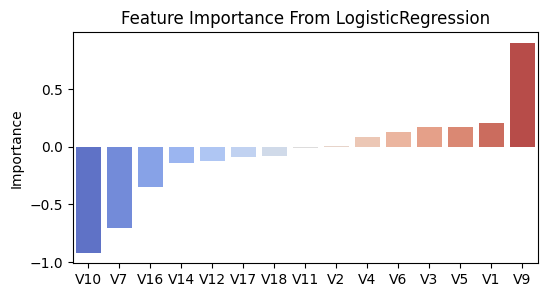

In [23]:
clf = LogisticRegression()
param_grid = {
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'C': [0.1, 1.0, 10.0],
    'fit_intercept': [True, False]
}
ini_best_estimator = train_test(clf, param_grid, 'LogisticRegression')

Feature importance is ranked by the magnitude of the model coefficients.

##### 4.1.2 Continue to fine-tune the model hyperparameters:
- Remove the unimportant features, i.e. magnitude of coefficient smaller than 0.01 to reduce the likelihood of overfit;
- Use warm start to continue tuning on a different set of parameters.

Best LogisticRegression Hyperparameters: {'C': 5.0, 'max_iter': 50, 'tol': 0.01}
Training ROC-AUC Score: 0.8867
Test ROC-AUC Score: 0.9061
              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00     56634
       Fraud       0.86      0.81      0.83       112

    accuracy                           1.00     56746
   macro avg       0.93      0.91      0.92     56746
weighted avg       1.00      1.00      1.00     56746

Time elapsed: 0.2 minutes


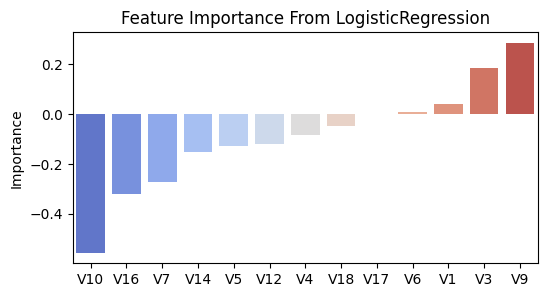

In [48]:
feature_to_keep_index = np.where(abs(ini_best_estimator.coef_[0])>0.01)[0]

clf_new = LogisticRegression(solver='lbfgs',fit_intercept=True, warm_start=True)
clf_new.coef_ = ini_best_estimator.coef_
clf_new.intercept_ = ini_best_estimator.intercept_

param_grid = {
    'tol': [0.01, 0.1, 0.2],
    'C': [1.0, 5.0, 10.0],
    'max_iter':[50, 100, 200]
}

best_estimator = train_test(clf_new, param_grid, 'LogisticRegression', plot_importance=True, feature_names=feature_to_keep, 
               X_train=X_train[:,feature_to_keep_index], y_train=y_train, X_test=X_test[:,feature_to_keep_index], y_test=y_test)


- The second iteration of the hyperparameter tuning significantly improved the precision meaning more fraud transections were correctly classified
- The training and test ROC-AUC scores are very close, suggesting no overfitting
- Features V10, V16, V7, V3 and V9 are found the most imortant features

#### 4.2 Random Forest Classifier
##### 4.2.1 Initial training

In [11]:
clf = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200, 250],
    'max_depth': [None, 10, 20],
}

ini_rf_estimator = train_test(clf, param_grid, 'RandomForest', False)

Best RandomForest Hyperparameters: {'max_depth': None, 'n_estimators': 200}
Training ROC-AUC Score: 1.0000
Test ROC-AUC Score: 0.9107
              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00     56634
       Fraud       0.93      0.82      0.87       112

    accuracy                           1.00     56746
   macro avg       0.96      0.91      0.94     56746
weighted avg       1.00      1.00      1.00     56746

Time elapsed: 154.5 minutes


##### 4.2.2 Continue to fine-tune the model hyperparameters:

Best RandomForest Hyperparameters: {'min_samples_leaf': 1, 'min_samples_split': 2}
Training ROC-AUC Score: 1.0000
Test ROC-AUC Score: 0.9151
              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00     56634
       Fraud       0.94      0.83      0.88       112

    accuracy                           1.00     56746
   macro avg       0.97      0.92      0.94     56746
weighted avg       1.00      1.00      1.00     56746

Time elapsed: 164.4 minutes


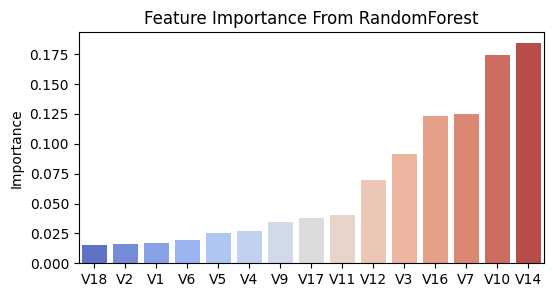

In [11]:
best_params = {'max_depth': None, 'n_estimators': 200}
clf = RandomForestClassifier(**best_params)
param_grid = {
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
best_rf_estimator = train_test(clf, param_grid, 'RandomForest')

- **The second iteration of the hyperparameter tuning only leads to slight improvement to the first training run, which was considerbly better than the logisgic regression results.**

#### 4.3 XGBoost Classifier

XGBoost doesn't support implementation within the GridSearchCV() framework. A simple grid search scheme is applied here using Logloss (or Cross-Entropy Loss) as loss function and the default scoring function (accuracy) for cross validation.<br>

##### 4.3.1 Initial model training

In [9]:
t1=time()

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 6, 10],               # Maximum depth of trees
    'learning_rate': [0.01, 0.1, 0.2],    # Step size shrinkage
    'subsample': [0.8, 1.0],              # Fraction of samples used for training
    'colsample_bytree': [0.8, 1.0],       # Fraction of features used for training
    'min_child_weight': [1, 3, 5],        # Minimum sum of instance weights
}

best_score = -1
best_params = None
accuracy = None
for params in ParameterGrid(param_grid):
    clf = XGBClassifier(objective='binary:logistic', eval_metric='logloss',**params)
    clf.fit(X_train, y_train)
    
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
        
    if train_score > best_score:
        best_score = train_score
        best_params = params
        accuracy = test_score

# accuracy = best_clf.score(X_test, y_test)
print(f'Best Hyperparameters: {best_params}')
print(f'Best Training Score: {best_score:.4f}')
print(f'Best Test Score: {accuracy:.4f}')
# best_estimator(clf, param_grid, X_train, y_train, X_test, y_test)
t2=time(); elapsed_min = (t2-t1)/60
print(f'Time elapsed: {elapsed_min:.1f} minutes')

Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 1.0}
Best Training Score: 1.0000
Best Test Score: 0.9995
Time elapsed: 4.0 minutes


In [66]:
# Calculate classification metrics
# best_params = {'learning_rate': 0.2, 'max_depth': 10}
clf = XGBClassifier(objective='binary:logistic', eval_metric='logloss',**best_params)
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_test)
train_score = roc_auc_score(y_train, y_pred_train, average='weighted')
test_score = roc_auc_score(y_test, y_pred, average='weighted') #best_estimator.score(X_test, y_test)
print(f'Training ROC-AUC Score: {train_score:.4f}')
print(f'Test ROC-AUC Score: {test_score:.4f}')

print(classification_report(y_test, y_pred, target_names=['Legit', 'Fraud']))
# sorted_feature_names

Training ROC-AUC Score: 0.9987
Test ROC-AUC Score: 0.9106
              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00     56634
       Fraud       0.90      0.82      0.86       112

    accuracy                           1.00     56746
   macro avg       0.95      0.91      0.93     56746
weighted avg       1.00      1.00      1.00     56746



Top-10 important Features: Index(['V2', 'V4', 'V6', 'V17', 'V5', 'V9', 'V16', 'V7', 'V14', 'V10'], dtype='object')


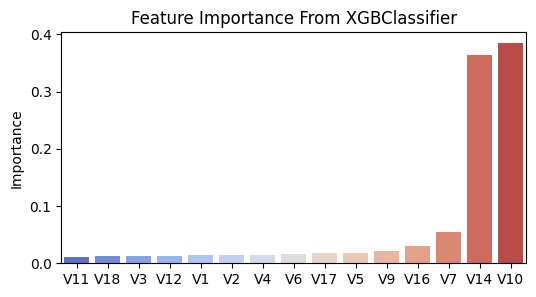

In [73]:
feature_importances = pd.Series(data=clf.feature_importances_,index=feature_names).sort_values(ascending=True)
top_features = feature_importances.index[-10:]

print(f'Top-10 important Features: {top_features}')
_, ax = plt.subplots(figsize=(6,3))
sns.barplot(x=feature_importances.index,y=feature_importances,palette='coolwarm',ax=ax)
ax.set(title='Feature Importance From XGBClassifier',xlabel='',ylabel='Importance')
plt.show()

- The feature importance of the best estimator indicates two variables stand out as the most import, others are in similarly low level of importance. Since there is no obvious trivial features, no one is removed.
  
##### 4.3.2 Retrain with additional hyperparameters

In [82]:
param_grid = {
    'max_depth': [10, 15, 20],               # Maximum depth of trees
    'learning_rate': [0.1, 0.15, 0.2],    # Step size shrinkage
    'gamma': [0, 0.1, 0.2],               # Minimum loss reduction for a split
    'reg_alpha': [0, 0.1, 1],             # L1 regularization term
    'reg_lambda': [0, 0.1, 1]             # L2 regularization term
}

best_score = -1
best_params = None
accuracy = None
for params in ParameterGrid(param_grid):
    clf = XGBClassifier(objective='binary:logistic', eval_metric='logloss',
                        colsample_bytree = 1.0, min_child_weight = 1, subsample = 1.0, **params)
    clf.fit(X_train, y_train)
    
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
        
    if train_score > best_score:
        best_score = train_score
        best_params = params
        accuracy = test_score

# accuracy = best_clf.score(X_test, y_test)
print(f'Best Hyperparameters: {best_params}')
print(f'Best Training Score: {best_score:.4f}')
print(f'Best Test Score: {accuracy:.4f}')

Best Hyperparameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 15, 'reg_alpha': 0, 'reg_lambda': 0}
Best Training Score: 1.0000
Best Test Score: 0.9995


In [84]:
# Calculate classification metrics
# best_params = {'colsample_bytree': 1.0, 'gamma': 0, 'min_child_weight': 1, 'subsample': 1.0}
clf = XGBClassifier(objective='binary:logistic', eval_metric='logloss',
                        colsample_bytree = 1.0, min_child_weight = 1, subsample = 1.0,
                    **best_params)
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_test)
train_score = roc_auc_score(y_train, y_pred_train, average='weighted')
test_score = roc_auc_score(y_test, y_pred, average='weighted') #best_estimator.score(X_test, y_test)
print(f'Training ROC-AUC Score: {train_score:.4f}')
print(f'Test ROC-AUC Score: {test_score:.4f}')

print(classification_report(y_test, y_pred, target_names=['Legit', 'Fraud']))

Training ROC-AUC Score: 0.9989
Test ROC-AUC Score: 0.9106
              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00     56634
       Fraud       0.90      0.82      0.86       112

    accuracy                           1.00     56746
   macro avg       0.95      0.91      0.93     56746
weighted avg       1.00      1.00      1.00     56746



#### 4.4 LightGBM Classifier
##### 4.4.1 Initial training

Best LightGBM Hyperparameters: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 70}
Training ROC-AUC Score: 0.9989
Test ROC-AUC Score: 0.9195
              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00     56634
       Fraud       0.89      0.84      0.86       112

    accuracy                           1.00     56746
   macro avg       0.94      0.92      0.93     56746
weighted avg       1.00      1.00      1.00     56746

Time elapsed: 10.2 minutes


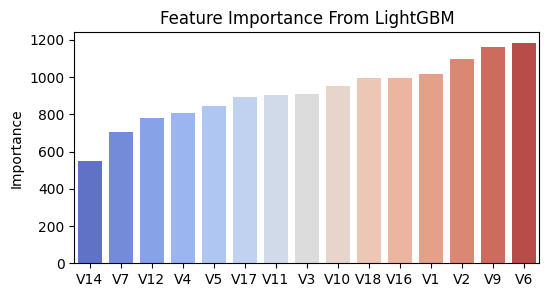

In [7]:
clf = lgb.LGBMClassifier(objective='binary', force_col_wise=True, verbosity=-1)

# Define the parameter grid
param_grid = {
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200]
}
ini_best_estimator = train_test(clf, param_grid, 'LightGBM', True)

- The feature importance of the best estimator shows no obvious weak features, so no feature is removed for the next step.
  
##### 4.4.2 Second iteration of hyperparameter tuning

In [ ]:
params={'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 70}

In [8]:
clf = lgb.LGBMClassifier(objective='binary', max_depth=-1, force_col_wise=True, learning_rate = 0.1, verbosity=-1)

# Define the parameter grid
param_grid = {
    'num_leaves': [50, 70, 90],
    'n_estimators': [150, 200, 250],
    'learning_rate': [0.1, 0.15, 0.2]
}
best_estimator = train_test(clf, param_grid, 'LightGBM', False)

Best LightGBM Hyperparameters: {'learning_rate': 0.1, 'n_estimators': 250, 'num_leaves': 70}
Training ROC-AUC Score: 0.9989
Test ROC-AUC Score: 0.9195
              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00     56634
       Fraud       0.90      0.84      0.87       112

    accuracy                           1.00     56746
   macro avg       0.95      0.92      0.93     56746
weighted avg       1.00      1.00      1.00     56746

Time elapsed: 10.4 minutes


- The second iteration improved the f1-score slightly (0.86 -> 0.87)

### 5. Discussion: strengths and weakness of classification models
Four classification methods were applied to detect the fraudulant transections in a credit card transections dataset. The dataset is relatively large (285.6k observations after SMOTE) with high dimensionality (30 initial features) and significant class imbalance. The SMOTE treatment is configured to only increase the minority class fraction from ~0.0017 to 0.01, so that 1) the sample size won't be too large for some classifiers and for the computational resources available; and 2) the classifiers can be evaluated in their ability to handle class imbalance. 

For a binary classification problem with such dataset, the pros and cons of the four methods are discussed below.<br>
- **Logistic Regression** is the fastest model to train, but its performance is relatively poorer compared to the other methods. It assumes linear relationship between features and the target. It tends to produce poor performance on imbalanced data.<br>
- **Random Forest** can model complex, non-linear relationships and handle class imbalance better. However, it is computationally expensive for large datasets. It produces the highest performance among the four methods.<br>
- **Gradient Boosting (XGBoost)** supports class weighting for imbalanced datasets and achieves similar performance compared to Random Forest, but relatively faster.<br>
- **LightGBM** trains faster than RandomForest and XGBoost and achieves similarly high performance.<br>

Overall, LightGBM is the most efficient classifier for a large, imbalanced dataset.